# Analyse the neb results

In [1]:
%aiida

Loaded AiiDA DB environment - profile name: quicksetup.

In [2]:
from aiida.orm import StructureData
import matplotlib.pyplot as plt

## Construct NEB frames - pymatgen

In [3]:
from pymatgen.analysis.transition_state import NEBAnalysis

def get_pmg_neb(workchain, energies_override=None):
    """Get an NEBAnalysis instance for an NEB workchain/calculation"""
    # Energy
    energies = {key: value['energy_without_entropy'] for key, value in workchain.outputs.neb_misc['neb_data'].items()}

    # Query for the energy computed for the end structures
    q = QueryBuilder()
    q.append(Node, filters={'id': workchain.inputs.initial_structure.id}, tag='root')
    q.append(CalcFunctionNode, with_outgoing='root', project=['attributes.function_name'])
    q.append(StructureData, with_outgoing=CalcFunctionNode, tag='relaxed', project=['label'], 
             #edge_filters={'label': 'init_structure'}, 
             edge_project=['label'])
    q.append(WorkflowNode, with_outgoing='relaxed', project=['label', 'uuid'], tag='relaxation', filters={'process_type': 'aiida.workflows:vaspu.relax'})
    q.append(Dict, with_incoming='relaxation', edge_filters={'label': 'misc'}, project=['attributes.total_energies.energy_extrapolated'])
    q.distinct()

    ends = {}
    end_id = '{:02d}'.format(len(energies) + 1)
    for _, _, _, relax_uuid, eng, label in q.all():
        if label.startswith('init'):
            if '00' in ends:
                print('Duplicated calculation: {relax_uuid} -> {eng} vs existing {existing}'.format(relax_uuid, eng=eng, existing=end['00']))
            else:
                ends['00'] = eng
            
        elif label.startswith('final'):
            if end_id in ends:
                print('Duplicated calculation: {relax_uuid} -> {eng} vs existing {existing}'.format(relax_uuid, eng=eng, existing=end[end_id]))
            else:
                ends[end_id] = eng

    energies.update(ends)
    if energies_override:
        energies.update(energies_override)
    
    # Structure
    neb_frames = []
    for i in range(1, 6):
        atoms = workchain.outputs.structure[f'image_{i:02d}'].get_pymatgen()
        neb_frames.append(atoms)
    neb_frames.insert(0, workchain.inputs.initial_structure.get_pymatgen())
    neb_frames.append(workchain.inputs.final_structure.get_pymatgen())

    # Forces

    forces_list = []
    neb_data = workchain.outputs.neb_misc['neb_data']
    for i in range(1, 6):
        forces = neb_data[f'{i:02d}']['tangents']
        forces_list.append(forces)

    forces_list.insert(0, np.zeros((3, len(workchain.inputs.initial_structure.sites))))
    forces_list.append(np.zeros((3, len(workchain.inputs.initial_structure.sites))))
    
    # Displacement
    r = [0]
    prev = neb_frames[0]
    for st in neb_frames[1:]:
        dists = np.array([s2.distance(s1) for s1, s2 in zip(prev, st)])
        r.append(np.sqrt(np.sum(dists ** 2)))
        prev = st
    r = np.cumsum(r)

    neb_analysis = NEBAnalysis(r, np.array([energies[f'{i:02d}'] for i in range(7)]), forces, neb_frames)
    return neb_analysis

### Li2Fe2S2O Paths

In [4]:
def load_and_plot(identifier, *args, **kwargs):
    """
    Load the NEB node and plot the path
    """
    workchain = load_node(identifier)
    neb_analysis = get_pmg_neb(workchain)

    x_points = neb_analysis.r
    y_points = neb_analysis.energies - neb_analysis.energies[0]
    plt.plot(x_points, y_points, '.', markersize=10)

    x_spline = np.linspace(x_points[0], x_points[-1], 100)
    y_spline = neb_analysis.spline(x_spline)#
    default_args = ['--']
    default_kwargs = {'color': 'xkcd:light blue'}
    default_kwargs.update(kwargs)
    if args:
        default_args = args
    plt.plot(x_spline, y_spline, *default_args, **default_kwargs)
    print(neb_analysis.get_extrema(normalize_rxn_coordinate=False))
    plt.xlabel('Reaction coordinate')
    plt.ylabel('Energy (eV)')
    return plt.gca(), neb_analysis

([], [(1.46, 383.90864865813666)])
([], [(2.02, 955.3848792588577)])


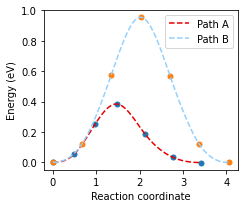

In [5]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(3.5, 3))
plt.sca(axs)
load_and_plot('2e54e54d-07bf-419a-b23e-ede4a6b83fc6', color='xkcd:red', label='Path A')
plt.legend()
plt.sca(axs)
load_and_plot('bcb2bf53-5700-4c0a-9827-2d2e676c2297', color='xkcd:light blue', label='Path B')
plt.legend(loc=1)
fig.tight_layout()
plt.savefig('li2fe2s2o-paths.png', dpi=200)

### Li4Fe3S3O2 PATHs

([], [(1.56, 301.6435560117683)])
([], [(3.04, 1743.5621640590623)])
([], [(1.71, 451.00264700489186)])
([(0.01, -0.00010907527336277866), (3.29, 550.3285986796773), (5.54, -1.7009252494193383)], [(2.29, 924.0348897264086), (3.8000000000000003, 603.1459961297851)])


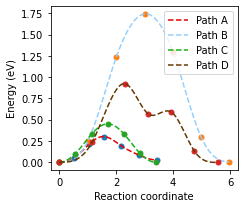

In [6]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(3.5, 3))
plt.sca(axs)
load_and_plot('1de9693e-86cf-43c0-a609-37bc6aa39d2f', color='xkcd:red', label='Path A')
plt.legend()
plt.sca(axs)
load_and_plot('79d580e9-b7c1-49d5-ada7-3291eb908397', color='xkcd:light blue', label='Path B')
load_and_plot('85d0ec5d-d138-419a-9895-89bbe8a7c3ca', color='xkcd:green', label='Path C')
load_and_plot('70b8309e-4fc9-4e0c-a995-7353ac8d87e0', color='xkcd:brown', label='Path D')

plt.legend(loc=1)

fig.tight_layout()
plt.savefig('li4fe3s3o2-paths.png', dpi=200)